### Solving Poisson Equation on S^2: $\Delta u = f$


In [72]:
import ducc0
import numpy as _np

In [73]:
ducc0.sht

<module 'ducc0.sht'>

In [65]:
# setup a few required variables
if ducc0 is not None:
    import os as _os

    try:
        nthreads = int(_os.environ["OMP_NUM_THREADS"])
    except:
        nthreads = 0


def set_nthreads(ntnew):
    global nthreads
    nthreads = ntnew



In [59]:
def _ralm2cilm(alm, lmax):
    cilm = _np.zeros((2, lmax + 1, lmax + 1), dtype=_np.float64)
    cilm[0, :, 0] = alm[0:lmax + 1].real
    ofs = lmax + 1
    for m in range(1, lmax + 1):
        cilm[0, m:, m] = alm[ofs:ofs + lmax + 1 - m].real
        cilm[1, m:, m] = alm[ofs:ofs + lmax + 1 - m].imag
        ofs += lmax + 1 - m
    return cilm
    
def _get_norm(lmax, norm):
    if norm == 1:
        return _np.full(lmax + 1, _np.sqrt(4 * _np.pi))
    if norm == 2:
        return _np.sqrt(4 * _np.pi / (2 * _np.arange(lmax + 1) + 1.0))
    if norm == 3:
        return _np.sqrt(2 * _np.pi / (2 * _np.arange(lmax + 1) + 1.0))
    if norm == 4:
        return _np.ones(lmax + 1)
    raise RuntimeError("unsupported normalization")

def _apply_norm(alm, lmax, norm, csphase, reverse):
    lnorm = _get_norm(lmax, norm)
    if reverse:
        lnorm = 1.0 / lnorm
    alm[0:lmax + 1] *= lnorm[0:lmax + 1]
    lnorm *= _np.sqrt(2.0) if reverse else (1.0 / _np.sqrt(2.0))
    mlnorm = -lnorm
    ofs = lmax + 1
    for m in range(1, lmax + 1):
        if csphase == 1:
            if m & 1:
                alm[ofs:ofs + lmax + 1 - m].real *= mlnorm[m:]
                alm[ofs:ofs + lmax + 1 - m].imag *= lnorm[m:]
            else:
                alm[ofs:ofs + lmax + 1 - m].real *= lnorm[m:]
                alm[ofs:ofs + lmax + 1 - m].imag *= mlnorm[m:]
        else:
            alm[ofs:ofs + lmax + 1 - m].real *= lnorm[m:]
            alm[ofs:ofs + lmax + 1 - m].imag *= mlnorm[m:]
        ofs += lmax + 1 - m
    if norm == 3:  # special treatment for unnormalized a_lm
        r = _np.arange(lmax + 1)
        fct = _np.ones(lmax + 1)
        ofs = lmax + 1
        if reverse:
            alm[0:lmax + 1] /= _np.sqrt(2)
            for m in range(1, lmax + 1):
                fct[m:] *= _np.sqrt((r[m:] + m) * (r[m:] - m + 1))
                alm[ofs:ofs + lmax + 1 - m] /= fct[m:]
                ofs += lmax + 1 - m
        else:
            alm[0:lmax + 1] *= _np.sqrt(2)
            for m in range(1, lmax + 1):
                fct[m:] *= _np.sqrt((r[m:] + m) * (r[m:] - m + 1))
                alm[ofs:ofs + lmax + 1 - m] *= fct[m:]
                ofs += lmax + 1 - m
    return alm


def _extract_alm(alm, lmax, norm, csphase):
    _apply_norm(alm, lmax, norm, csphase, True)
    return _ralm2cilm(alm, lmax)

In [71]:
def _analyze_DH_adjoint(map, lmax):
    alm = ducc0.sht.experimental.adjoint_synthesis_2d(
        map=map.reshape((1, map.shape[0], map.shape[1])),
        spin=0,
        lmax=lmax,
        geometry="DH",
        nthreads=nthreads,
    )
    return alm[0]

def _analyze_DH(map, lmax):
    alm = ducc0.sht.experimental.analysis_2d(
        map=map.reshape((1, map.shape[0], map.shape[1])),
        spin=0,
        lmax=lmax,
        geometry="DH",
        nthreads=nthreads,
    )
    return alm[0]

In [74]:
def SHExpandDH(grid, norm=1, sampling=1, csphase=1, lmax_calc=None, flag = False):
    if grid.shape[1] != sampling * grid.shape[0]:
        raise RuntimeError("grid resolution mismatch")
    if lmax_calc is None:
        lmax_calc = grid.shape[0] // 2 - 1
    if lmax_calc > (grid.shape[0] // 2 - 1):
        raise RuntimeError("lmax_calc too high")
    if flag:
        alm = _analyze_DH_adjoint(grid, lmax_calc)
    else:
        alm = _analyze_DH(grid, lmax_calc)
    return _extract_alm(alm, lmax_calc, norm, csphase)

In [34]:
# from ducc0_wrapper import SHExpandDH
# from ducc0_wrapper import MakeGridDH
# import ducc0
# import ducc0_wrapper as ducc0

In [68]:
import torch

from Basis import SPHBasis
from Problem import Problem_Sphere_Poisson
from Model import Model
from Net import Sphere_Net, SPH_Sphere_Net
import seaborn as sns
import matplotlib.pyplot as plt
import math
from math import pi
from spherical_harmonics import *
from torch.distributions.uniform import Uniform
from numpy import arccos

import pyshtools
from pyshtools.shio import shread
from pyshtools.expand import MakeGridDH
# from pyshtools.expand import SHExpandDH
from pyshtools.spectralanalysis import spectrum

torch.manual_seed(0)
maxiter = 1000
problem = Problem_Sphere_Poisson()

In [36]:
N = 13
#             cos_azimuth = torch.linspace(-0.9999, 0.9999, N, requires_grad=False)
#             azimuth = torch.arccos(cos_azimuth)
azimuth = torch.linspace(0.0001, pi, N, requires_grad=False)
polar = torch.linspace(0, 2*pi, 2*N, requires_grad=False)

## noise
#             dpolar = 2*pi/(2*N-1)
#             dazimuth = 2.0/(N-1)
#             polar_noise = torch.distributions.Uniform(low = -dpolar/2, high = dpolar/2).sample(sample_shape=torch.Size(polar.shape))
#             azimuth_noise = torch.distributions.Uniform(low = -dazimuth/2, high = dazimuth/2).sample(sample_shape=torch.Size(azimuth.shape))            
#             azimuth, polar = azimuth + azimuth_noise, polar + polar_noise

azimuth, polar = torch.meshgrid(azimuth, polar)
location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
location.shape

torch.Size([338, 2])

iteration 0: loss = 34.229164123535156


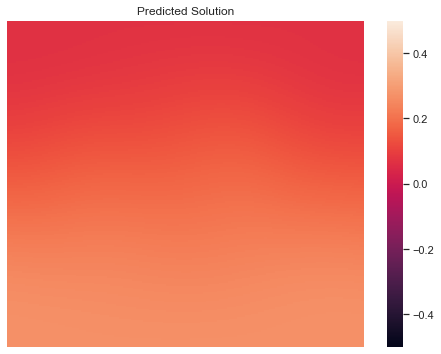

-----------------------------
[[[ 1.73420608e-01  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-5.79719618e-02 -4.37355274e-03  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-1.37008098e-03 -4.10986552e-03 -1.56551029e-03 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 8.02041811e-09 -1.13147799e-07  1.47754829e-11 ...  1.48232751e-08
    0.00000000e+00  0.00000000e+00]
  [-7.36833927e-09  1.11663326e-07  1.04042785e-09 ... -1.65343330e-08
    1.46572861e-08  0.00000000e+00]
  [ 9.33198674e-09 -1.10334007e-07 -1.66119982e-11 ...  1.02792983e-08
   -1.64429537e-08  1.45246029e-08]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -1.35475257e-03  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -3.71363654e-04  1.15831790e-03 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]

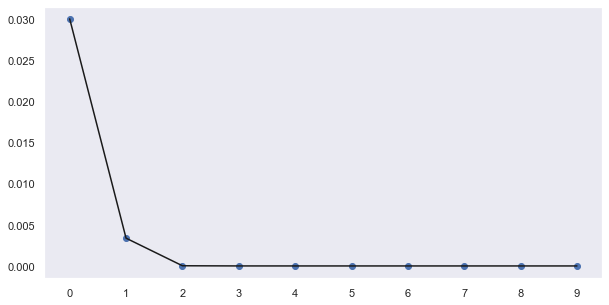

iteration 10: loss = 33.981056213378906
iteration 20: loss = 33.53938293457031
iteration 30: loss = 32.837127685546875
iteration 40: loss = 32.6321907043457
iteration 50: loss = 32.501590728759766
iteration 60: loss = 32.337520599365234
iteration 70: loss = 31.77635383605957
iteration 80: loss = 30.769878387451172
iteration 90: loss = 29.479829788208008
iteration 100: loss = 28.412574768066406


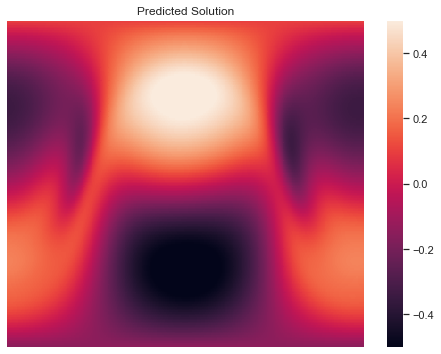

-----------------------------
[[[-2.89309788e-02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 7.71608725e-02 -1.68691762e-02  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-9.08026879e-04 -2.33092621e-01  3.90494359e-03 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 1.23364092e-08 -8.00440193e-06  2.36490738e-08 ... -2.62969252e-07
    0.00000000e+00  0.00000000e+00]
  [ 1.53162070e-08  7.90334616e-06  2.64860045e-08 ... -9.19987215e-08
   -2.64408669e-07  0.00000000e+00]
  [ 1.03428635e-08 -7.80479240e-06  2.17110188e-08 ... -1.73257135e-07
   -9.06793645e-08 -2.65455867e-07]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.75029710e-02  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  8.60278402e-03  2.83620576e-03 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]

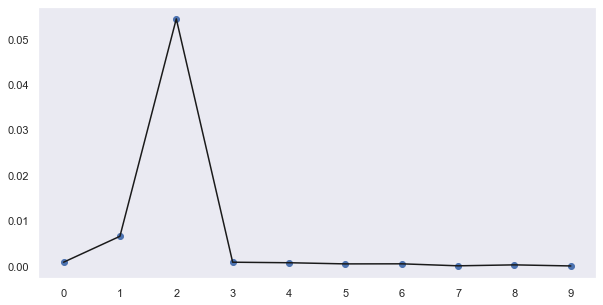

iteration 110: loss = 27.466997146606445
iteration 120: loss = 26.035022735595703
iteration 130: loss = 24.325281143188477
iteration 140: loss = 23.04570960998535
iteration 150: loss = 21.65970802307129
iteration 160: loss = 20.141876220703125
iteration 170: loss = 18.935462951660156
iteration 180: loss = 17.524682998657227
iteration 190: loss = 15.995734214782715
iteration 200: loss = 14.671329498291016


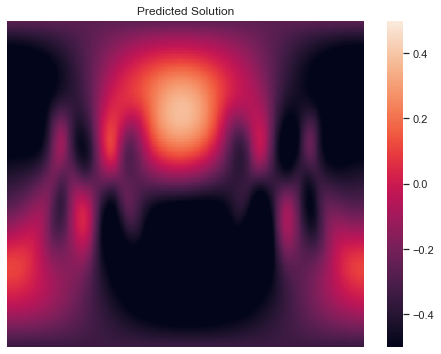

-----------------------------
[[[-3.11008126e-01  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 6.22851476e-02 -1.68815367e-02  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.07008789e-03 -2.40796342e-01 -2.08414160e-03 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 5.45632055e-08 -7.16445538e-06  5.86231153e-08 ... -1.02103957e-06
    0.00000000e+00  0.00000000e+00]
  [-2.29525376e-08  7.07253730e-06 -4.02409217e-09 ...  3.77742033e-08
   -1.01919136e-06  0.00000000e+00]
  [ 4.86078484e-08 -6.98537315e-06  5.50866055e-08 ... -6.73279715e-07
    3.81106737e-08 -1.01962280e-06]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  4.35148254e-02  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  8.78581253e-04  1.00248004e-03 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]

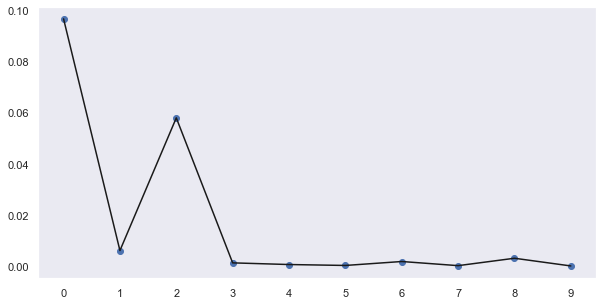

iteration 210: loss = 13.867383003234863
iteration 220: loss = 13.12826919555664
iteration 230: loss = 12.278162956237793
iteration 240: loss = 11.0143461227417
iteration 250: loss = 9.021712303161621
iteration 260: loss = 6.67930793762207
iteration 270: loss = 5.089004039764404
iteration 280: loss = 4.013103485107422
iteration 290: loss = 3.052891254425049
iteration 300: loss = 2.2461702823638916


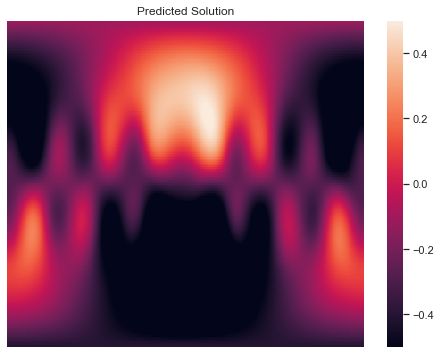

-----------------------------
[[[-2.55684137e-01  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.08771846e-01  6.14633737e-03  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-8.50337557e-04 -2.86978513e-01 -1.58745386e-02 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 3.70153579e-08 -9.75610874e-06 -3.32696821e-08 ... -2.15698037e-06
    0.00000000e+00  0.00000000e+00]
  [-5.13027976e-09  9.63241564e-06  8.57538254e-08 ... -6.17208968e-07
   -2.14970783e-06  0.00000000e+00]
  [ 3.24326699e-08 -9.51309448e-06 -2.97658538e-08 ... -1.14576312e-06
   -5.97110727e-07 -2.14203897e-06]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  6.97882893e-03  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.52525055e-04  1.92597788e-02 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]

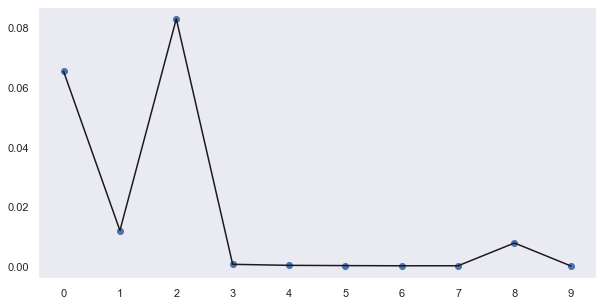

iteration 310: loss = 1.4632645845413208
iteration 320: loss = 0.9157574772834778
iteration 330: loss = 0.5996449589729309
iteration 340: loss = 0.4282105267047882
iteration 350: loss = 0.31710416078567505
iteration 360: loss = 0.2500780522823334
iteration 370: loss = 0.2139490246772766
iteration 380: loss = 0.17640627920627594
iteration 390: loss = 0.15511612594127655
iteration 400: loss = 0.12587064504623413


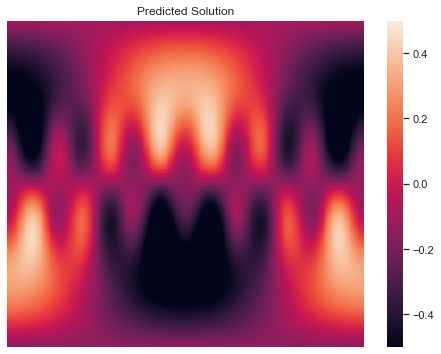

-----------------------------
[[[-1.24665193e-01  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 2.06020940e-02  1.63076296e-02  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 2.26859120e-03 -2.58881718e-01 -4.53343336e-03 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 3.67719935e-08 -8.60707587e-06  2.41648141e-08 ... -2.98800899e-07
    0.00000000e+00  0.00000000e+00]
  [-8.69691785e-09  8.49871412e-06  2.74173342e-08 ... -9.32065632e-07
   -3.00050232e-07  0.00000000e+00]
  [ 3.53837208e-08 -8.39495533e-06  2.23668568e-08 ... -2.15353765e-07
   -9.09623054e-07 -3.00023942e-07]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  9.07674432e-03  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  7.41987769e-03  8.80615413e-03 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]

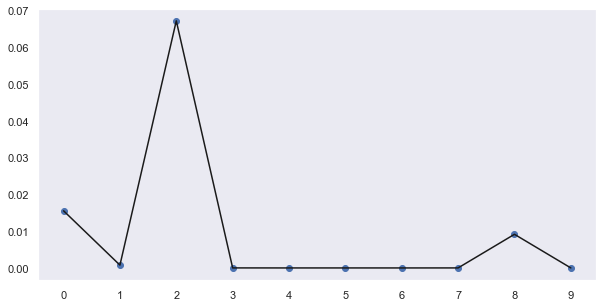

iteration 410: loss = 0.11202012002468109
iteration 420: loss = 0.10574331879615784
iteration 430: loss = 0.09621433168649673
iteration 440: loss = 0.09025058150291443
iteration 450: loss = 0.07953652739524841
iteration 460: loss = 0.0627288967370987
iteration 470: loss = 0.06657689064741135
iteration 480: loss = 0.06364918500185013
iteration 490: loss = 0.058472827076911926
iteration 500: loss = 0.07081145793199539


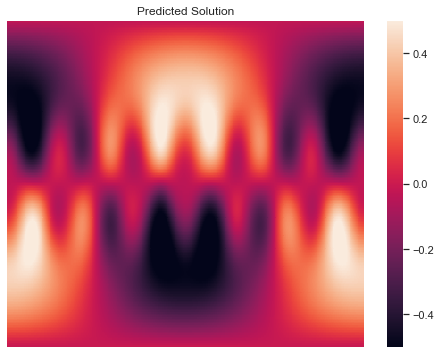

-----------------------------
[[[-2.52593309e-02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-1.65988889e-03  5.44683589e-03  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.91236055e-03 -2.57830113e-01 -1.10935152e-03 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 3.97244051e-08 -8.12843155e-06  2.16826823e-08 ...  1.84854827e-07
    0.00000000e+00  0.00000000e+00]
  [-1.04027551e-08  8.02703653e-06  2.90443953e-08 ... -9.03738851e-07
    1.82738049e-07  0.00000000e+00]
  [ 3.62880748e-08 -7.92689298e-06  1.96640180e-08 ... -6.40384856e-09
   -8.78534479e-07  1.81636338e-07]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -9.91406734e-04  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  3.93427582e-03  3.04343784e-03 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]

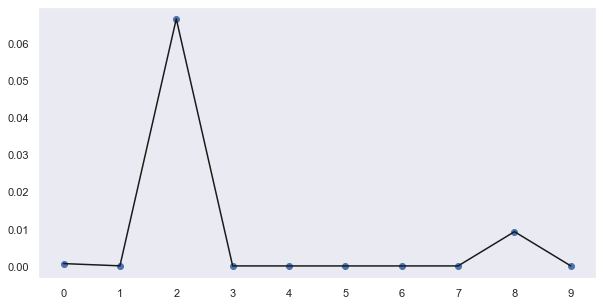

iteration 510: loss = 0.06264068186283112
iteration 520: loss = 0.05160755664110184
iteration 530: loss = 0.06308300048112869
iteration 540: loss = 0.04144147038459778
iteration 550: loss = 0.052316877990961075
iteration 560: loss = 0.045307986438274384
iteration 570: loss = 0.035140011459589005
iteration 580: loss = 0.04123830050230026
iteration 590: loss = 0.03802495822310448
iteration 600: loss = 0.033190369606018066


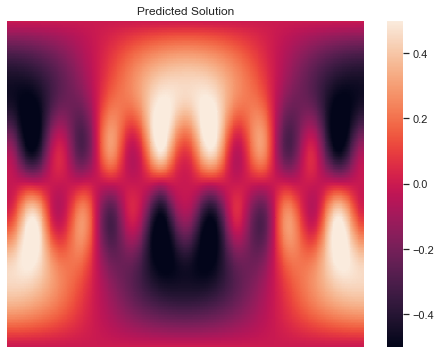

-----------------------------
[[[-5.02143800e-03  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-2.35112006e-04  5.43303671e-04  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.41897018e-03 -2.57311642e-01 -2.92223674e-04 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 1.86793478e-08 -8.26836640e-06  4.58694558e-08 ...  3.06147456e-07
    0.00000000e+00  0.00000000e+00]
  [ 9.83395410e-09  8.16458123e-06  4.65051464e-09 ... -8.74704085e-07
    3.05535991e-07  0.00000000e+00]
  [ 1.66845595e-08 -8.06535445e-06  4.45525536e-08 ...  2.39368845e-08
   -8.51392031e-07  3.05266695e-07]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -2.33391696e-03  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  2.71106628e-03  1.45318673e-03 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]

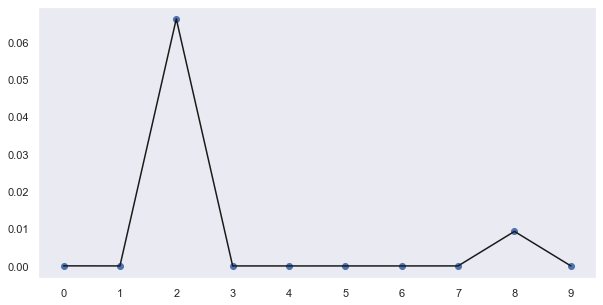

iteration 610: loss = 0.03504904732108116
iteration 620: loss = 0.0287768691778183
iteration 630: loss = 0.07771322131156921
iteration 640: loss = 0.03341224417090416
iteration 650: loss = 0.050646428018808365
iteration 660: loss = 0.026329433545470238
iteration 670: loss = 0.03667951002717018
iteration 680: loss = 0.03139456734061241
iteration 690: loss = 0.03343338519334793
iteration 700: loss = 0.04700856655836105


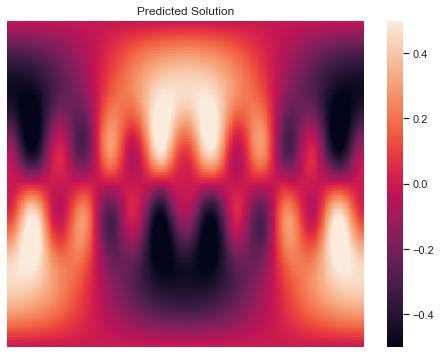

-----------------------------
[[[-4.56005754e-03  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-2.53540929e-03  3.75000061e-03  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-5.06165670e-04 -2.57504523e-01  2.24341755e-03 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 2.87172988e-08 -8.62205798e-06  3.59549510e-08 ...  3.11805962e-07
    0.00000000e+00  0.00000000e+00]
  [-2.12148105e-10  8.51360528e-06  1.57889932e-08 ... -8.38195831e-07
    3.10239358e-07  0.00000000e+00]
  [ 2.64672408e-08 -8.40974462e-06  3.37065202e-08 ...  6.52595356e-09
   -8.13540396e-07  3.09556214e-07]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -1.07333274e-03  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  2.60613812e-03  1.17923040e-03 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]

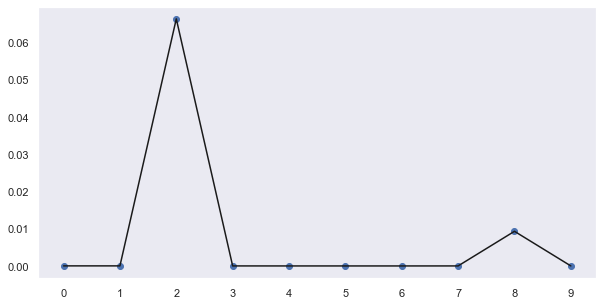

iteration 710: loss = 0.027694957330822945
iteration 720: loss = 0.03774023801088333
iteration 730: loss = 0.025874266400933266
iteration 740: loss = 0.03901604562997818
iteration 750: loss = 0.03125142306089401
iteration 760: loss = 0.035846047103405
iteration 770: loss = 0.020809415727853775
iteration 780: loss = 0.021595356985926628
iteration 790: loss = 0.029685309156775475
iteration 800: loss = 0.03233860433101654


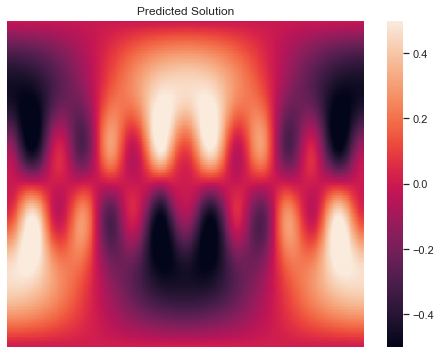

-----------------------------
[[[ 7.77428912e-04  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-3.60995601e-03  2.79861479e-03  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 3.42504965e-04 -2.57913709e-01  1.41732139e-03 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 3.07630330e-08 -8.43313228e-06  3.84913399e-08 ...  3.22972369e-07
    0.00000000e+00  0.00000000e+00]
  [-2.81416734e-09  8.32469505e-06  1.41817607e-08 ... -8.13687450e-07
    3.20499964e-07  0.00000000e+00]
  [ 3.03431520e-08 -8.22176298e-06  3.59987418e-08 ...  2.99311975e-09
   -7.89973399e-07  3.20401568e-07]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -1.15567597e-03  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  2.63191760e-03  1.16486638e-03 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]

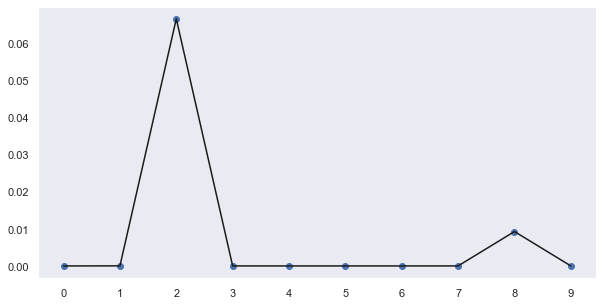

iteration 810: loss = 0.025512048974633217
iteration 820: loss = 0.02567310631275177
iteration 830: loss = 0.028804577887058258
iteration 840: loss = 0.025659168139100075
iteration 850: loss = 0.0515984483063221
iteration 860: loss = 0.022159500047564507
iteration 870: loss = 0.026412099599838257
iteration 880: loss = 0.01764216274023056
iteration 890: loss = 0.026073968037962914
iteration 900: loss = 0.027706963941454887


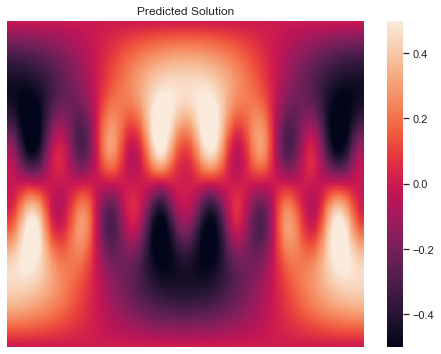

-----------------------------
[[[ 6.41438586e-04  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-2.55636801e-03 -3.65113863e-03  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.46256282e-03 -2.56356567e-01  1.26641535e-03 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 2.50950887e-08 -8.43138059e-06  4.07447409e-08 ...  4.52239505e-07
    0.00000000e+00  0.00000000e+00]
  [ 4.43224257e-09  8.32587830e-06  1.11026468e-08 ... -7.93099730e-07
    4.53190836e-07  0.00000000e+00]
  [ 2.41335858e-08 -8.22262882e-06  3.80554255e-08 ...  6.96674505e-08
   -7.71237808e-07  4.52565985e-07]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -1.61958183e-03  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  2.67993403e-03  7.79659720e-04 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]

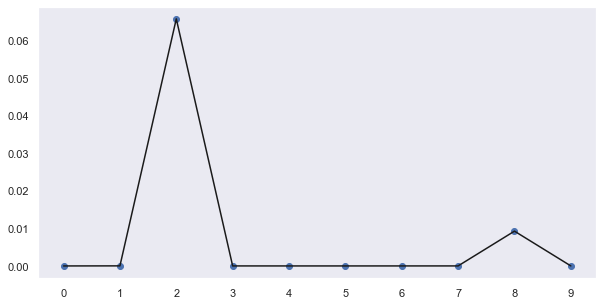

iteration 910: loss = 0.020479850471019745
iteration 920: loss = 0.027075491845607758
iteration 930: loss = 0.030908888205885887
iteration 940: loss = 0.04400571808218956
iteration 950: loss = 0.022828521206974983
iteration 960: loss = 0.041852161288261414
iteration 970: loss = 0.03268495574593544
iteration 980: loss = 0.02136933244764805
iteration 990: loss = 0.025890864431858063


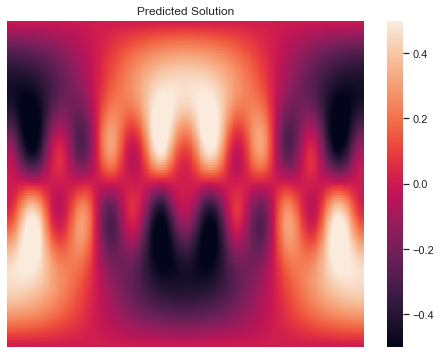

-----------------------------
[[[ 8.63195583e-03  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-1.56974932e-03 -4.48277715e-04  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 4.53480352e-05 -2.57503867e-01 -4.87042096e-04 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 1.46353107e-08 -8.49544722e-06  4.50310509e-08 ...  4.03314630e-07
    0.00000000e+00  0.00000000e+00]
  [ 1.34910687e-08  8.38841697e-06  7.13085280e-09 ... -7.86853263e-07
    4.02096333e-07  0.00000000e+00]
  [ 1.49702348e-08 -8.28537486e-06  4.19831991e-08 ...  4.12409200e-08
   -7.62551167e-07  4.01205909e-07]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -2.58167158e-03  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  2.56369566e-03  1.63326843e-03 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]

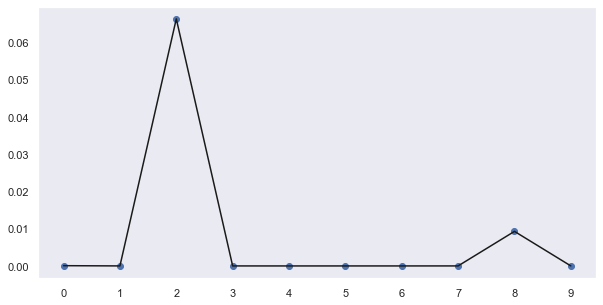

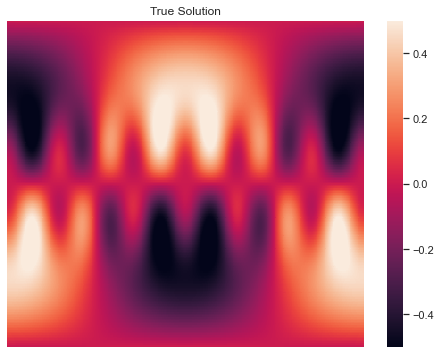

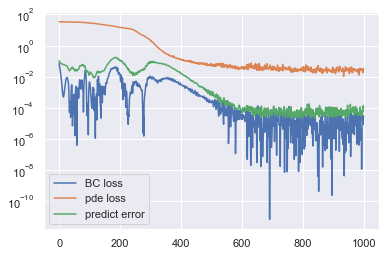

In [78]:

def construct_model(net):
    class Poisson1dModel(Model):
        def add_loss_history(self):
            self.loss_history.append([self.bc_loss, self.pde_loss, self.predict_error_value])

        def __init__(self):
            super().__init__(problem=problem, net=net, maxiter=maxiter)

        def inner_sample(self, N=15):
#             N = 25
#             cos_azimuth = torch.linspace(-0.9999, 0.9999, N, requires_grad=False)
#             azimuth = torch.arccos(cos_azimuth)
            azimuth = torch.linspace(0.0001, pi, N, requires_grad=False)
            polar = torch.linspace(0, 2*pi, 2*N, requires_grad=False)
            
            ## noise
#             dpolar = 2*pi/(2*N-1)
#             dazimuth = 2.0/(N-1)
#             polar_noise = torch.distributions.Uniform(low = -dpolar/2, high = dpolar/2).sample(sample_shape=torch.Size(polar.shape))
#             azimuth_noise = torch.distributions.Uniform(low = -dazimuth/2, high = dazimuth/2).sample(sample_shape=torch.Size(azimuth.shape))            
#             azimuth, polar = azimuth + azimuth_noise, polar + polar_noise

            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            return location
#             x = torch.randn(num, 3)
#             x = x / (torch.norm(x, dim=1).reshape((-1, 1)))
        
#             polar = torch.atan(x[:, :1] / x[:, 1:2]) + math.pi / 2
#             polar[:num // 2, 0] = polar[:num // 2, 0] + math.pi
#             azimuth = torch.acos(x[:, 2:3])
            
#             ## noise
#             dpolar = 2 * pi/(num-1) 
#             polar_noise = polar + torch.distributions.Uniform(low = -dpolar/2, high = dpolar/2).sample(sample_shape=torch.Size(polar.shape))
            
#             dazimuth = pi/(num-1) 
#             azimuth_noise = azimuth + torch.distributions.Uniform(low = -dazimuth/2, high = dazimuth/2).sample(sample_shape=torch.Size(polar.shape))            
            
#             x = torch.cat([azimuth_noise, polar_noise], dim=1)
#             return x

        def bc_sample(self):
            return torch.tensor([[1., 1.]])

        def init_sample(self):
            pass

        def plot(self, net):
            azimuth = torch.linspace(0, math.pi, 200, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 400, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            value = net(location)
            
            value = value.reshape((200, 400))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Predicted Solution")
            plt.show()
            
            self.spherical_harmonic_transform(net)
        
        def spherical_harmonic_transform(self, net):
            azimuth = torch.linspace(0, math.pi, 200, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 400, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            function_grid = net(location)
            function_grid = function_grid.reshape((200, 400))
            
#             print(f'grid dims{function_grid}')
            
            ## if flag = True, compute adjoint instead
            coefficients = SHExpandDH(function_grid.detach().numpy(), sampling=2,flag = False)
            print("-----------------------------")
            print(coefficients)
            print("-----------------------------")
            nl = coefficients.shape[1]
            ls = _np.arange(nl)[:10]
#             print(ls)

            power_per_l = spectrum(coefficients)[:10]
#             print(power_per_l)
            fig, ax = plt.subplots(1, 1, figsize=(len(ls), 5))
            ax.plot(ls, power_per_l, 'bo')
            ax.plot(ls, power_per_l, 'k-')
            plt.xticks(range(len(ls)))
            # ax.set_yscale('log')
            # ax.set_xscale('log')
            ax.grid()
            plt.show()
            
        
        def plot_true(self):
            azimuth = torch.linspace(0, math.pi, 200, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 400, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            value = true_solution(location[:, 0:1], location[:, 1:])
            
            value = value.reshape((200, 400))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("True Solution")
            plt.show()
            
        def post_process(self, ax=None):
            if ax is None:
                plt.plot(self.loss_history)
                plt.yscale('log')
                plt.legend(('BC loss', 'pde loss', 'predict error'))
                plt.show()
            else:
                ax.plot(self.loss_history)
                ax.set_yscale('log')
                ax.set_ylim(1e-4, 100)
                ax.legend(('BC loss', 'pde loss', 'predict error'))

        def predict_error(self):
            coor = self.inner_sample(N=20)
            true = self.problem.ground_truth(coor)
            predict = self.net(coor)
            predict_error = self.pde_loss_f(true, predict)
            return predict_error

        def train(self, ax100=None):
            problem = self.problem
            net = self.net
            opt = self.opt
            maxiter = self.maxiter

            for iter in range(maxiter):
                net.zero_grad()

                coor_inner = self.inner_sample().detach().requires_grad_(True)
                infer_value_inner = net(coor_inner)
                truth_inner, predict_inner = problem.pde(coor_inner, infer_value_inner)
                self.pde_loss = self.pde_loss_f(predict_inner, truth_inner)

                bc_samples = self.bc_sample()
                if bc_samples is None:
                    self.bc_loss = torch.tensor(0.)
                else:
                    coor_bc = bc_samples.detach().requires_grad_(True)
                    infer_value_bc = net(coor_bc)
                    truth_bc, predict_bc = problem.bound_condition(coor_bc, infer_value_bc)
                    self.bc_loss = self.bc_loss_f(predict_bc, truth_bc)

                init_samples = self.init_sample()
                if init_samples is None:
                    self.init_loss = torch.tensor(0.)
                else:
                    coor_init = init_samples.detach().requires_grad_(True)
                    infer_value_init = net(coor_init)
                    truth_init, predict_init = problem.bound_condition(coor_init, infer_value_init)
                    self.init_loss = self.bc_loss_f(predict_init, truth_init)
                self.predict_error_value = self.predict_error()
                self.total_loss = self.pde_loss + self.bc_loss + self.init_loss
                self.add_loss_history()
                self.total_loss.backward()

                opt.step()
                opt.zero_grad()
                
                for i in range(len(self.loss_history)):
                    for j in range(3):
                        self.loss_history[i][j] = self.loss_history[i][j].detach().requires_grad_(False)
                        
                if iter % (maxiter // 100) == 0:
                    print("iteration {}: loss = {}".format(iter, self.total_loss))
                        
                if iter % int(maxiter / 10) == 0:
                    self.plot(net)
                
            self.plot(net)
            self.plot_true()
            self.post_process()

    return Poisson1dModel()

model = construct_model(Sphere_Net([3, 50, 50, 50, 16, 1]))
model.train()
